1. Постановка задачи.
2. Препроцессим данные.
3. Токенизуем текст на слова.
4. Возьмем предобученный Word2Vec, получим из него эмбеддинги слов.
5. Паддинг в текстах
6. Соберем Dataset и DataLoader из текстов.
7. Обучаем модель регрессии над текстом.

## Постановка задачи


Требуется по заголовку объявления и его тексту предсказать, какую зарплату за это объявление предложат.

Датасет возьмем из соревнования ["Job Salary Prediction"](https://www.kaggle.com/competitions/job-salary-prediction/data).

В качестве метрики качества будем рассматривать MAE, подсчитанную на логарифме таргета.

В качестве модели возьмем TextCNN, оптимизатор Adam.

## Смотрим на данные, препроцессим их

In [1]:
import pandas as pd

# Данные скачать отсюда https://www.kaggle.com/competitions/job-salary-prediction/data
# Нас интересует Train_rev1.csv
data = pd.read_csv("Train_rev1.csv", index_col=None)
print(data.shape)
data.head(2)

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk


In [2]:
from sklearn.model_selection import train_test_split

seed = 0
data_train_val, data_test = train_test_split(data, test_size=0.2, random_state=seed)
data, data_val = train_test_split(data_train_val, test_size=0.2, random_state=seed)

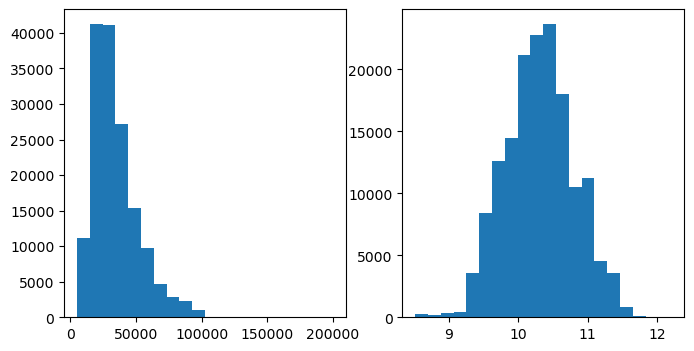

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20);

In [4]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"


data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
163757,71227035,Commercial Analyst,An immediate opportunity has arisen for a Comm...,UK,UK,full_time,permanent,Randstad Financial & Professional,Accounting & Finance Jobs,"From 23,000 to 28,000 per year",25500,fish4.co.uk,10.146473
19951,67107296,cleaner,Temporary Cleaner Required Duties Mopping Floo...,Reading,Reading,full_time,NaN,CA Support Services,Maintenance Jobs,7.00 - 7.00 per hour,13440,Jobcentre Plus,9.506065
8573,65247027,Head of UK Business Risk and Oversight Assurance,Precis Head of UK Business Risk and Oversight ...,Surrey,Surrey,NaN,permanent,PSD Group,Accounting & Finance Jobs,"90,000 - 105,000",97500,jobsincredit.com,11.487617


## Токенизация


Воспользуемся пакетом `nltk` для разбиения текста на токены. В качестве токенов будем использовать отдельные слова.

In [5]:
import nltk
import tqdm

data.fillna({"Title": "NaN"}, inplace=True)
tokenizer = nltk.tokenize.WordPunctTokenizer()
for col in ("FullDescription", "Title"):
    tmp = [" ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])]
    data[col] = tmp

100%|██████████████████████████████████████████████████████████████████████| 156651/156651 [00:00<00:00, 290070.00it/s]


In [6]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
104939,69575041,nursery manager,bretsa early years are working in partnership ...,City of London - London,The City,full_time,permanent,UKStaffsearch,Other/General Jobs,32000 - 35000,33500,ukstaffsearch.com,10.419331
45543,68546313,retail advisor – gateshead cameron walk ( part...,retail advisor – gateshead cameron walk ( part...,Gateshead,Gateshead,part_time,NaN,O2,Graduate Jobs,12907,12907,careerbuilder.com,9.465603
164172,71240807,finance manager london,my client is a global organisation looking for...,London,London,full_time,permanent,Warner Scott Recruitment,Accounting & Finance Jobs,60000,60000,strike-jobs.co.uk,11.002116
20726,67238188,"weekend showroom host , high wycombe , motor t...","automotive , motor trade job : showroom host r...",Buckinghamshire - High Wycombe,High Wycombe,full_time,permanent,CVbrowser,Hospitality & Catering Jobs,5460,5460,cvbrowser.com,8.605387
194925,71797155,registered nurses ( rgn ' s rmn ' s & rnld ' s ),we currently have vacancies for qualified nurs...,Wiltshire - Salisbury,Salisbury,full_time,permanent,CVbrowser,Healthcare & Nursing Jobs,25500 - 33500,29500,cvbrowser.com,10.292179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16291,66888760,assembly test technician aerospace,the assembly & test technician performs produc...,Berkshire,Berkshire,NaN,contract,JAM Recruitment Ltd,Other/General Jobs,12 - 16/hour,26880,cv-library.co.uk,10.199175
47190,68574162,buyer,experienced buyer required to work for my clie...,Devon - Barnstaple,Barnstaple,full_time,permanent,UKStaffsearch,Trade & Construction Jobs,25000 - 30000,27500,ukstaffsearch.com,10.221977
220460,72372678,"1st / 2nd line support windos xp / 7 , office ...",1st / 2nd line support windows xp /**** office...,Yorkshire,Yorkshire and Humberside,NaN,contract,Senitor Associates,IT Jobs,9.00 - 13.00 GBP Hourly,21120,jobserve.com,9.958023
74663,69000616,"hgv / lcv technician , coventry , motor trade job","automotive , motor trade job : hgv / lcv techn...","Coventry, West Midlands",Coventry,NaN,permanent,Perfect Placement,Other/General Jobs,23000/annum,23000,cv-library.co.uk,10.043293


In [7]:
data['FullDescription']

104939    bretsa early years are working in partnership ...
45543     retail advisor – gateshead cameron walk ( part...
164172    my client is a global organisation looking for...
20726     automotive , motor trade job : showroom host r...
194925    we currently have vacancies for qualified nurs...
                                ...                        
16291     the assembly & test technician performs produc...
47190     experienced buyer required to work for my clie...
220460    1st / 2nd line support windows xp /**** office...
74663     automotive , motor trade job : hgv / lcv techn...
202334    our client are a premium high street brand and...
Name: FullDescription, Length: 156651, dtype: object

In [8]:
data['FullDescription'].map(len)

104939     823
45543      794
164172    1900
20726     3393
194925     648
          ... 
16291     2344
47190     1128
220460     461
74663     2417
202334    1283
Name: FullDescription, Length: 156651, dtype: int64

In [9]:
data['FullDescription'].loc[104939]

'bretsa early years are working in partnership with a wellestablished , friendly nursery in barnet to help recruit for a nursery manager . you will be managing a large nursery with a large staff team ; experience of managing a large nursery is essential . this is a full time position . you will need to have the following qualifications , training and experience : qualified to nneb / nvq level 3 / cache level 3 / btec national in childcare or equivalent 23 years experience of managerial / supervisory or similar role in an early years setting sound knowledge of early years foundation stage knowledge of ofsted standards excellent rates of pay , bonuses and benefits with ongoing support and career development . please send your most up to date cv for a brief chat and for an interview as soon as you are able to attend'

In [10]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer

# Запроцессим категориальные фичи:
# - заполним пропуски
# - возьмем топ 2к компаний;
# - сделаем OHE над колонками;
data[categorical_columns] = data[categorical_columns].fillna("NaN")
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [11]:
data[categorical_columns].apply(dict, axis=1)

104939    {'Category': 'Other/General Jobs', 'Company': ...
45543     {'Category': 'Graduate Jobs', 'Company': 'Othe...
164172    {'Category': 'Accounting & Finance Jobs', 'Com...
20726     {'Category': 'Hospitality & Catering Jobs', 'C...
194925    {'Category': 'Healthcare & Nursing Jobs', 'Com...
                                ...                        
16291     {'Category': 'Other/General Jobs', 'Company': ...
47190     {'Category': 'Trade & Construction Jobs', 'Com...
220460    {'Category': 'IT Jobs', 'Company': 'Senitor As...
74663     {'Category': 'Other/General Jobs', 'Company': ...
202334    {'Category': 'Retail Jobs', 'Company': 'Henry ...
Length: 156651, dtype: object

In [12]:
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))

In [13]:
Counter(data["Company"])

Counter({'Other': 61011,
         'NaN': 20706,
         'UKStaffsearch': 3233,
         'CVbrowser': 1880,
         'London4Jobs': 1496,
         'Hays': 1162,
         'JAM Recruitment Ltd': 744,
         'Office Angels': 606,
         'Jobsite Jobs': 597,
         'Perfect Placement': 576,
         'ARRAY': 537,
         'Matchtech Group plc.': 535,
         'JOBG8': 513,
         'Penguin Recruitment': 499,
         'Randstad': 482,
         'Michael Page Finance': 437,
         'Adecco': 433,
         'Adecco Group': 375,
         'BMS Sales Specialists LLP': 363,
         'Page Personnel Finance': 341,
         'COREcruitment International': 337,
         'Michael Page Sales': 325,
         'Capita Resourcing': 311,
         'Matchtech': 301,
         'Rise Technical Recruitment Ltd': 299,
         'Huxley Associates': 286,
         'Experis IT': 282,
         'Brookstreet UK': 276,
         'Support Services Group': 272,
         'Interaction Recruitment': 270,
         'ATA Rec

## Эмбеддинги

Эмбеддинг - это векторное представление токена.
Для получения из токена его эмбеддинг будем использовать `word2vec`, предобученный на `Google News`.

In [14]:
import gensim.downloader as api

wv = api.load("word2vec-google-news-300")
print(type(wv))
print(wv.get_vector("map").shape)
print(wv.has_index_for('map'))

<class 'gensim.models.keyedvectors.KeyedVectors'>
(300,)
True


In [15]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
104939,69575041,nursery manager,bretsa early years are working in partnership ...,City of London - London,The City,full_time,permanent,UKStaffsearch,Other/General Jobs,32000 - 35000,33500,ukstaffsearch.com,10.419331
45543,68546313,retail advisor – gateshead cameron walk ( part...,retail advisor – gateshead cameron walk ( part...,Gateshead,Gateshead,part_time,NaN,Other,Graduate Jobs,12907,12907,careerbuilder.com,9.465603
164172,71240807,finance manager london,my client is a global organisation looking for...,London,London,full_time,permanent,Other,Accounting & Finance Jobs,60000,60000,strike-jobs.co.uk,11.002116
20726,67238188,"weekend showroom host , high wycombe , motor t...","automotive , motor trade job : showroom host r...",Buckinghamshire - High Wycombe,High Wycombe,full_time,permanent,CVbrowser,Hospitality & Catering Jobs,5460,5460,cvbrowser.com,8.605387
194925,71797155,registered nurses ( rgn ' s rmn ' s & rnld ' s ),we currently have vacancies for qualified nurs...,Wiltshire - Salisbury,Salisbury,full_time,permanent,CVbrowser,Healthcare & Nursing Jobs,25500 - 33500,29500,cvbrowser.com,10.292179
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16291,66888760,assembly test technician aerospace,the assembly & test technician performs produc...,Berkshire,Berkshire,NaN,contract,JAM Recruitment Ltd,Other/General Jobs,12 - 16/hour,26880,cv-library.co.uk,10.199175
47190,68574162,buyer,experienced buyer required to work for my clie...,Devon - Barnstaple,Barnstaple,full_time,permanent,UKStaffsearch,Trade & Construction Jobs,25000 - 30000,27500,ukstaffsearch.com,10.221977
220460,72372678,"1st / 2nd line support windos xp / 7 , office ...",1st / 2nd line support windows xp /**** office...,Yorkshire,Yorkshire and Humberside,NaN,contract,Senitor Associates,IT Jobs,9.00 - 13.00 GBP Hourly,21120,jobserve.com,9.958023
74663,69000616,"hgv / lcv technician , coventry , motor trade job","automotive , motor trade job : hgv / lcv techn...","Coventry, West Midlands",Coventry,NaN,permanent,Perfect Placement,Other/General Jobs,23000/annum,23000,cv-library.co.uk,10.043293


In [16]:
take_first_n = 1_000

# Весь датасет не влезет в RAM, будем бить на батчи
# Возьмите subset = data - и увидите, что не помещается
subset = data.iloc[:100].copy()
for col in ("FullDescription", "Title"):
    new_data = [
        np.stack(
            [
                wv.get_vector(x)
                for x in tokens.split()[:take_first_n]
                if wv.has_index_for(x)
            ]
        )
        for tokens in tqdm.tqdm(subset[col])
    ]
    subset[f"emb_{col}"] = new_data

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 8280.79it/s]


In [17]:
# тексты разной длины
subset["emb_FullDescription"]

104939    [[0.18945312, 0.08300781, -0.014404297, 0.0839...
45543     [[0.10498047, -0.040039062, -0.30664062, 0.043...
164172    [[0.14453125, 0.04711914, 0.10058594, 0.328125...
20726     [[0.033447266, -0.037597656, -0.06933594, 0.11...
194925    [[-0.017944336, 0.1171875, 0.052734375, 0.2558...
                                ...                        
174632    [[0.080078125, 0.10498047, 0.049804688, 0.0534...
175751    [[0.10986328, -0.08496094, 0.11669922, 0.12695...
183638    [[0.004425049, 0.016723633, -0.33007812, -0.12...
208091    [[0.24511719, 0.265625, -0.08935547, -0.114257...
198073    [[-0.017944336, 0.1171875, 0.052734375, 0.2558...
Name: emb_FullDescription, Length: 100, dtype: object

## Паддинг
Помним, что когда объединяем в батч, все размерности должны быть одинаковы.

Чтобы суметь собрать тексты разной длины в один батч, приведем все предложения к одной длине.
Для этого добавим некоторый специальный символ - например, `<PAD>`.

В `word2vec-google-news-300` нет явного символа паддинга (обычно это `<PAD>`),
но мы можем взять любой другой символ, который точно не встречается в текстах.

In [18]:
# Возьмем </s> - только проверим, что его нет в наших текстах
wv.index_to_key[:10]

['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said']

In [19]:
wv.index_to_key

['</s>',
 'in',
 'for',
 'that',
 'is',
 'on',
 '##',
 'The',
 'with',
 'said',
 'was',
 'the',
 'at',
 'not',
 'as',
 'it',
 'be',
 'from',
 'by',
 'are',
 'I',
 'have',
 'he',
 'will',
 'has',
 '####',
 'his',
 'an',
 'this',
 'or',
 'their',
 'who',
 'they',
 'but',
 '$',
 'had',
 'year',
 'were',
 'we',
 'more',
 '###',
 'up',
 'been',
 'you',
 'its',
 'one',
 'about',
 'would',
 'which',
 'out',
 'can',
 'It',
 'all',
 'also',
 'two',
 'after',
 'first',
 'He',
 'do',
 'time',
 'than',
 'when',
 'We',
 'over',
 'last',
 'new',
 'other',
 'her',
 'people',
 'into',
 'In',
 'our',
 'there',
 'A',
 'she',
 'could',
 'just',
 'years',
 'some',
 'U.S.',
 'three',
 'million',
 'them',
 'what',
 'But',
 'so',
 'no',
 'like',
 'if',
 'only',
 'percent',
 'get',
 'did',
 'him',
 'game',
 'back',
 'because',
 'now',
 '#.#',
 'before',
 'company',
 'any',
 'team',
 'against',
 'off',
 'This',
 'most',
 'made',
 'through',
 'make',
 'second',
 'state',
 'well',
 'day',
 'season',
 'says',
 'w

In [20]:
data["Title"].map(lambda tokens: "<s>" in tokens)

104939    False
45543     False
164172    False
20726     False
194925    False
          ...  
16291     False
47190     False
220460    False
74663     False
202334    False
Name: Title, Length: 156651, dtype: bool

In [21]:
# Оба assert проходит - значит, </s> можно использовать как токен для паддинга
assert 0 == data["Title"].map(lambda tokens: "</s>" in tokens).sum()
assert 0 == data["FullDescription"].map(lambda tokens: "</s>" in tokens).sum()

In [22]:
def pad(series: pd.Series, pad_length: int, pad_token: str = "</s>"):
    return series.map(
        lambda tokens: " ".join(
            tokens.split() + [pad_token] * max(0, pad_length - len(tokens.split()))))

In [23]:
pad(subset["Title"], 15)

104939    nursery manager </s> </s> </s> </s> </s> </s> ...
45543     retail advisor – gateshead cameron walk ( part...
164172    finance manager london </s> </s> </s> </s> </s...
20726     weekend showroom host , high wycombe , motor t...
194925    registered nurses ( rgn ' s rmn ' s & rnld ' s...
                                ...                        
174632    business development manager </s> </s> </s> </...
175751    actuarial systems manager life </s> </s> </s> ...
183638    gearbox and pump fitters ( electro mechanical ...
208091    locum nurse practitioner suffolk </s> </s> </s...
198073    sales engineer </s> </s> </s> </s> </s> </s> <...
Name: Title, Length: 100, dtype: object

In [24]:
# Эту функцию дальше не будем использовать, но она демонстрирует идею паддинга
def pad_sequence(series: pd.Series, pad_length: int, pad_token: str = "</s>"):
    return series.map(
        lambda tokens: " ".join(
            tokens.split() + [pad_token] * max(0, pad_length - len(tokens.split()))
        )
    )


pad_sequence(subset["Title"], 15).head(15)

104939    nursery manager </s> </s> </s> </s> </s> </s> ...
45543     retail advisor – gateshead cameron walk ( part...
164172    finance manager london </s> </s> </s> </s> </s...
20726     weekend showroom host , high wycombe , motor t...
194925    registered nurses ( rgn ' s rmn ' s & rnld ' s...
222927    field sales executive portable appliance / ele...
206627    real estate partner </s> </s> </s> </s> </s> <...
127166    clinical advisor patient monitoring </s> </s> ...
123545    retail sales consultant </s> </s> </s> </s> </...
42842     senior systems analyst </s> </s> </s> </s> </s...
60993     digital graphic design manager asda </s> </s> ...
32378     materials planner / stock controller / buyer <...
122579    cnc machine operator </s> </s> </s> </s> </s> ...
150341    hr business partner cipd charitable organisati...
80759     evening cleaner hilton birmingham metropole </...
Name: Title, dtype: object

То, что видим выше - это типичный результат после применения паддинга.

In [25]:
def pad_or_trim_to_length(pad_length, vectors, pad_vector):
    assert pad_vector.ndim ==1
    
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors.tolist()
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)

In [26]:
pad_or_trim_to_length(50, subset['emb_Title'].loc[104939], wv.get_vector('</s>')).shape

(50, 300)

In [27]:
wv.get_vector('</s>').shape

(300,)

In [28]:
np.array([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]]).shape

(2, 5)

In [29]:
from collections.abc import Collection
from gensim.models import KeyedVectors

# Оба assert проходит - значит, </s> можно использовать как токен для паддинга
assert 0 == data["Title"].map(lambda tokens: "</s>" in tokens).sum()
assert 0 == data["FullDescription"].map(lambda tokens: "</s>" in tokens).sum()


def pad_or_trim_to_length(
    pad_length: int, vectors: list[np.ndarray], pad_vector: np.ndarray
):
    assert pad_vector.ndim == 1
    # допаддим слева, а если превысили - обрежем с конца
    vectors = vectors[:pad_length] + [pad_vector] * max(0, pad_length - len(vectors))
    return np.stack(vectors)


def seq_to_emb(
    sentences: Collection[str], wv: KeyedVectors, pad_length: int, pad_token: str = "</s>"
):
    rv = []
    for sentence in sentences:
        sentence_embeddings = []
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_length(
            pad_length, sentence_embeddings, wv.get_vector(pad_token)
        )
        rv.append(np.stack(sentence_embeddings))
    return np.stack(rv)

seq_to_emb(subset["Title"], wv, 50).shape

(100, 50, 300)

In [30]:
def pad_or_trim_to_lenght(pad_length: int, vectors: list, emb_pad: np.ndarray) -> np.ndarray:
    assert emb_pad.ndim == 1
    
    return np.stack(vectors[:pad_length] + [emb_pad] * max(0, pad_length - len(vectors)))


def seq_to_emb(sentences, wv, pad_length, emb_pad: str = "</s>"):
    rv = []
    for sentence in sentences:
        sentence_embeddings = []
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_lenght(pad_length, sentence_embeddings, wv.get_vector(emb_pad))
        
        rv.append(np.stack(sentence_embeddings))
    return np.stack(rv)
        

In [31]:
seq_to_emb(subset["Title"], wv, 50).shape

(100, 50, 300)

In [32]:
# Какую длину в паддинге выбрать? Подсчитаем по датасету
print(
    "Максимальное количество токенов в колонке 'Title':",
    data["Title"].map(lambda x: x.split()).map(len).max(),
)
print(
    "Максимальное количество токенов в колонке 'FullDescription':",
    data["FullDescription"].map(lambda x: x.split()).map(len).max(),
)
# Возьмем 40 и 2317 - почему бы и нет?

Максимальное количество токенов в колонке 'Title': 40
Максимальное количество токенов в колонке 'FullDescription': 2317


## Собираем Dataset и DataLoader

In [33]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]

# Запроцессим категориальные фичи:
# - заполним пропуски
# - возьмем топ 2к компаний;
# - сделаем OHE над колонками;
data[categorical_columns] = data[categorical_columns].fillna("NaN")
top_companies, top_counts = zip(*Counter(data["Company"]).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(
    lambda comp: comp if comp in recognized_companies else "Other"
)
categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [34]:
data[categorical_columns].apply(dict, axis=1)

104939    {'Category': 'Other/General Jobs', 'Company': ...
45543     {'Category': 'Graduate Jobs', 'Company': 'Othe...
164172    {'Category': 'Accounting & Finance Jobs', 'Com...
20726     {'Category': 'Hospitality & Catering Jobs', 'C...
194925    {'Category': 'Healthcare & Nursing Jobs', 'Com...
                                ...                        
16291     {'Category': 'Other/General Jobs', 'Company': ...
47190     {'Category': 'Trade & Construction Jobs', 'Com...
220460    {'Category': 'IT Jobs', 'Company': 'Senitor As...
74663     {'Category': 'Other/General Jobs', 'Company': ...
202334    {'Category': 'Retail Jobs', 'Company': 'Henry ...
Length: 156651, dtype: object

In [35]:
categorical_vectorizer

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [36]:
categorical_vectorizer.feature_names_

['Category=Accounting & Finance Jobs',
 'Category=Admin Jobs',
 'Category=Charity & Voluntary Jobs',
 'Category=Consultancy Jobs',
 'Category=Creative & Design Jobs',
 'Category=Customer Services Jobs',
 'Category=Domestic help & Cleaning Jobs',
 'Category=Energy, Oil & Gas Jobs',
 'Category=Engineering Jobs',
 'Category=Graduate Jobs',
 'Category=HR & Recruitment Jobs',
 'Category=Healthcare & Nursing Jobs',
 'Category=Hospitality & Catering Jobs',
 'Category=IT Jobs',
 'Category=Legal Jobs',
 'Category=Logistics & Warehouse Jobs',
 'Category=Maintenance Jobs',
 'Category=Manufacturing Jobs',
 'Category=Other/General Jobs',
 'Category=PR, Advertising & Marketing Jobs',
 'Category=Part time Jobs',
 'Category=Property Jobs',
 'Category=Retail Jobs',
 'Category=Sales Jobs',
 'Category=Scientific & QA Jobs',
 'Category=Social work Jobs',
 'Category=Teaching Jobs',
 'Category=Trade & Construction Jobs',
 'Category=Travel Jobs',
 'Company=1st Executive Ltd',
 'Company=1st Place',
 'Company=

In [37]:
def pad_or_trim_to_lenght(pad_length: int, vectors: list, emb_pad: np.ndarray) -> np.ndarray:
    assert emb_pad.ndim == 1
    
    return np.stack(vectors[:pad_length] + [emb_pad] * max(0, pad_length - len(vectors)))


def seq_to_emb(sentences, wv, pad_length, emb_pad: str = "</s>"):
    rv = []
    for sentence in sentences:
        sentence_embeddings = []
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_lenght(pad_length, sentence_embeddings, wv.get_vector(emb_pad))
        
        rv.append(np.stack(sentence_embeddings))
    return np.stack(rv)

In [38]:
# Соберем все в датасет, который запроцессит данные, токенизует и превратит в эмбеддинги
from torch.utils.data import Dataset
import torch


class CvTextDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        pad_title_len: int,
        pad_desc_len: int,
        wv: KeyedVectors,
        categorical_vectorizer: DictVectorizer,
    ):
        # Далее будут те коды препроцессинга, что писали ранее
        self.target_column = "Log1pSalary"
        data[self.target_column] = np.log1p(data["SalaryNormalized"]).astype("float32")

        # Кат. фичи: заполнить пропуски, взять топ популярных компаний и OHE
        data[categorical_columns] = data[categorical_columns].fillna("NaN")
        top_companies, _ = zip(*Counter(data["Company"]).most_common(2000))
        recognized_companies = set(top_companies)
        data["Company"] = data["Company"].apply(
            lambda comp: comp if comp in recognized_companies else "Other"
        )
        self.categorical_vectorizer = categorical_vectorizer

        # Текстовые фичи: токенизация
        self.text_columns = ["Title", "FullDescription"]
        data.fillna({k: "NaN" for k in self.text_columns}, inplace=True)
        tokenizer = nltk.tokenize.WordPunctTokenizer()
        for col in self.text_columns:
            tmp = [
                " ".join(tokenizer.tokenize(x)).lower() for x in tqdm.tqdm(data[col])
            ]
            data[col] = tmp
        self.pad_len_for_column = {
            "Title": pad_title_len,
            "FullDescription": pad_desc_len,
        }

        self.wv = wv
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor, float]:
        one_row = self.data.iloc[index]
        target = one_row[self.target_column]
        rv = {}
        # Сначала две текстовые колонки, потом категориальные
        for one_feature in self.text_columns:
            rv[one_feature] = torch.from_numpy(
                seq_to_emb(
                    [one_row[one_feature]],
                    wv=self.wv,
                    pad_length=self.pad_len_for_column[one_feature],
                )
            ).squeeze(0)
        for one_feature in categorical_columns:
            rv[one_feature] = torch.from_numpy(
                self.categorical_vectorizer.transform(
                    {one_feature: one_row[one_feature]}
                )
            ).squeeze(0)
        rv[self.target_column] = target
        return rv

In [39]:
train_dataset = CvTextDataset(
    data,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
val_dataset = CvTextDataset(
    data_val,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
test_dataset = CvTextDataset(
    data_test,
    pad_title_len=40,
    pad_desc_len=2317,
    wv=wv,
    categorical_vectorizer=categorical_vectorizer,
)
# print(len(train_dataset))
print(len(test_dataset))
x = test_dataset[0]
print(type(x["Title"]), type(x["FullDescription"]))
print(
    x["Title"].shape,
    x["FullDescription"].shape,
    x["Company"].shape,
    x["Log1pSalary"].shape,
)

100%|█████████████████████████████████████████████████████████████████████████| 48954/48954 [00:04<00:00, 10750.96it/s]

48954
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([40, 300]) torch.Size([2317, 300]) torch.Size([3402]) ()


In [40]:
x.keys()

dict_keys(['Title', 'FullDescription', 'Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'Log1pSalary'])

In [41]:
import os
import random


def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)


def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)


enable_determinism()
fix_seeds(0)

In [45]:
train_dataset[0]

{'Title': tensor([[-7.6660e-02,  2.2125e-03,  7.0312e-02,  ...,  3.5645e-02,
           1.0693e-01,  2.8906e-01],
         [-1.6406e-01, -6.1768e-02, -5.4199e-02,  ..., -3.2959e-02,
           1.9336e-01, -5.9326e-02],
         [ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
          -1.2302e-04, -8.6308e-05],
         ...,
         [ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
          -1.2302e-04, -8.6308e-05],
         [ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
          -1.2302e-04, -8.6308e-05],
         [ 1.1292e-03, -8.9645e-04,  3.1853e-04,  ..., -1.5640e-03,
          -1.2302e-04, -8.6308e-05]]),
 'FullDescription': tensor([[ 1.8945e-01,  8.3008e-02, -1.4404e-02,  ..., -5.2246e-02,
           5.7129e-02,  1.7456e-02],
         [-1.2695e-01,  2.0898e-01, -1.0645e-01,  ...,  1.3477e-01,
           1.8799e-02, -1.4844e-01],
         [-9.6680e-02, -2.6367e-02,  9.0332e-02,  ..., -1.9653e-02,
           2.1387e-01,  1.3672e-01],
         ..

In [46]:
from torch.utils.data import DataLoader

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    worker_init_fn=seed_worker,
    generator=g,
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)

In [51]:
for batch in train_loader:
    print(batch['Title'].shape)
    break

torch.Size([32, 40, 300])


## TextCNN

Одна из самых ранних моделей в мире NLP. [Статья](https://arxiv.org/abs/1408.5882).
Архитектура следующая:

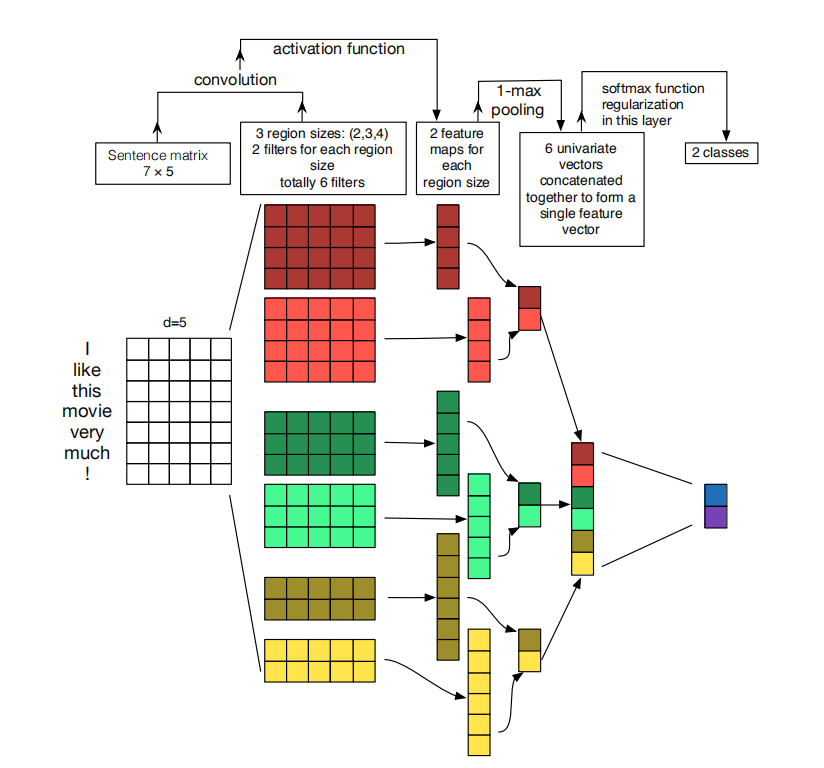

6 ядер, по 2 ядра размерами 2, 3 и 4 соответственно. Затем MaxPool.
Все выходы сшиваются в один вектор - и передаются в FC слой.

Мы сделаем то же самое, но добавим еще один ингредиент - категориальные фичи.
Их прогоним через FC, соединим с вектором из других выходов - и точно так же подадим в финальный FC слой.

<center><img src="./final-arch.png"></center>

In [40]:
len(categorical_vectorizer.vocabulary_)

3402

In [41]:
for i, key in enumerate(categorical_columns):
    x = data[key]
    print(x)
    break

104939             Other/General Jobs
45543                   Graduate Jobs
164172      Accounting & Finance Jobs
20726     Hospitality & Catering Jobs
194925      Healthcare & Nursing Jobs
                     ...             
16291              Other/General Jobs
47190       Trade & Construction Jobs
220460                        IT Jobs
74663              Other/General Jobs
202334                    Retail Jobs
Name: Category, Length: 156651, dtype: object


In [42]:
len(categorical_vectorizer.vocabulary_)

3402

In [41]:
import torch.nn as nn

filter_sizes = [2, 3, 4]
num_filters = 2


class TextCnn(nn.Module):
    def __init__(self):
        super().__init__()
        emb_size = 300
        self.text_filters = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Conv1d(emb_size, num_filters, kernel_size=filter_sizes[i]),
                    nn.ReLU(),
                )
                for i in range(len(filter_sizes))
            ]
        )
        self.cat_network = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(len(categorical_vectorizer.vocabulary_), num_filters),
                    nn.ReLU(),
                )
                for _ in range(len(categorical_columns))
            ]
        )
        self.fc = nn.Linear(
            num_filters
            * (len(filter_sizes) * len(text_columns) + len(categorical_columns)),
            1,
        )

    def forward(self, data: dict[str, torch.Tensor]):
        to_fc = []
        for key in text_columns:
            x = data[key]
            rv = []
            for f in self.text_filters:
                # Свертка - выдаст [(bs, 2, n - 1), (bs, 2, n - 2), (bs, 2, n - 3)]
                result = f(x.permute((0, 2, 1)))
                # MaxPooling вдоль предложения - даст [(bs, 2), (bs, 2), (bs, 2)]
                result = torch.max(result, dim=2)[0]
                rv.append(result)
            x = torch.concat(rv, dim=1)
            to_fc.append(x)

        for i, key in enumerate(categorical_columns):
            x = data[key]
            x = self.cat_network[i](x)
            to_fc.append(x)

        x = torch.hstack(to_fc)
        x = self.fc(x).squeeze(1)
        return x

In [ ]:
model = TextCnn()
model(next(iter(test_loader))).shape

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn.functional as F
import wandb
from torch.optim import Adam

loss_fn = F.l1_loss


@torch.no_grad
def loss_on_dataset(model: nn.Module, loader: DataLoader, device: torch.device):
    model.to(device).eval()
    loss = 0
    for x in loader:
        x = {k: v.to(device) for k, v in x.items()}
        pred = model(x)
        loss = loss + loss_fn(pred, x[TARGET_COLUMN])
    model.train()
    return (loss / len(loader)).item()


def train_loop(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
):
    optimizer = Adam(model.parameters(), lr=1e-4)
    n_epochs = 6
    model.to(device).train()
    wandb.watch(model, criterion=loss_fn, log="parameters", log_freq=100)
    for _ in range(n_epochs):
        for x in tqdm.tqdm(train_loader):
            x = {k: v.to(device) for k, v in x.items()}
            pred = model(x)
            loss = loss_fn(pred, x[TARGET_COLUMN])
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            wandb.log({"loss": loss.item()})
        wandb.log({"val_loss": loss_on_dataset(model, val_loader, device)})
    return optimizer


wandb.init(project="start-dl--lesson-6")
train_loop(model, train_loader, val_loader, device)

In [ ]:
# Подсчитаем, насколько модель ошибается на test датасете
model.to(device).eval()
losses = []
for x in tqdm.tqdm(test_loader):
    x = {k: v.to(device) for k, v in x.items()}
    with torch.no_grad():
        pred = model(x)
    for i in range(pred.shape[0]):
        losses.append((pred - x[TARGET_COLUMN])[i].item())

In [ ]:
plt.hist(losses, bins=200)
plt.xlim((-4, 5));

In [ ]:
np.mean(losses)



1. Попробовать другие эмбеддинги. Например, [fasttext](https://radimrehurek.com/gensim/models/fasttext.html).
2. Добавить больше фильтров. У нас их на все ядра по 2 штуки - как в оригинальной статье. Но можно больше.

